# Data Challenge

## Course: Kernel Methods for Machine Learning
### M2-MVA (ENS-Paris Saclay)

Authors: Carlos Cuevas Villarmin and Javier Alejandro Lopetegui Gonzalez

**0. Import libraries**

In [52]:
import pickle as pkl
from scipy.linalg import cho_factor, cho_solve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**0. Import kernels and classifiers**

In [53]:
from kernels import RBF, LinearKernel
from classifiers import KernelSVC, MulticlassKernelSVC

**1. Load training data.** Data is divided into three files. On the one hand the training data is provided in *Xtr.csv* and its corresponding labels in *Ytr.csv*. On the other hand, test data is in *Xte.csv* but it will be loaded once the model is trained.

The information about the structure of the data provided by the authors of the challenge is the following:

- Xtr.csv contains a matrix of size 5000 x 3072. One row represents a color image of size 32 x 32 pixels. The first 1024 values represent pixel intensities on the red channel, then the next 1024 represent the green channel, and the last 1024 entries, the blue channel. To make sure that you are reading the data correctly, you need to find a way to visualize images. Note that images have been pre-processed, and do not appear as a natural image.

- Ytr.csv contains a vector of labels corresponding to the training data, in the same format as a submission file. 

- Xte.csv contains 2000 test images. These are the ones you need to classify. The first row corresponds to image Id=1, then the last row corresponds to image Id=2000.

Taking it into account the first step is to load the data.

In [54]:
data_path = 'data/'

#Read training data
Xtr = np.array(pd.read_csv(data_path+'Xtr.csv',header=None,sep=',',usecols=range(3072))) #Drop the last column of Xtr because it is generated by the format of the data but it is unnecessary.
Ytr = np.array(pd.read_csv(data_path+'Ytr.csv',sep=',',usecols=[1])).squeeze() 

#Read test data
Xte = np.array(pd.read_csv(data_path+'/Xte.csv',header=None,sep=',',usecols=range(3072))) ##Drop the last column of Xte because it is generated by the format of the data but it is unnecessary.

# define your learning algorithm here 
# # for instance, define an object called ``classifier'' 
# # classifier.train(Ytr,Xtr) 
# # predict on the test data 
# # for instance, Yte = classifier.fit(Xte) 
# Yte = {'Prediction' : Yte} 
# dataframe = pd.DataFrame(Yte) dataframe.index += 1 
# dataframe.to_csv('Yte_pred.csv',index_label='Id') 

In [55]:
#Transform into pandas dataframe
X_train_df = pd.DataFrame(Xtr)
Y_train_df = pd.DataFrame(Ytr, columns=['Prediction'])

#Visualize the data
display(X_train_df.head())
display(Y_train_df.head())

print(X_train_df.shape, Y_train_df.shape)


,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.007018,0.000323,0.002215,0.000781,-0.005636,-0.001525,-0.001090,-0.001907,0.004179,-0.004225,...,0.004146,-0.002166,-0.005094,0.001906,-0.006143,-0.013265,-0.013873,0.005223,-0.000860,-0.012881
1,0.000819,0.001688,0.002698,0.004685,0.011166,0.017482,0.045989,0.031377,0.032150,0.062066,...,-0.000530,0.007203,0.008634,0.006800,0.014114,0.000243,-0.019384,-0.046763,-0.048919,-0.057449
2,-0.016779,0.006662,-0.007226,-0.003798,-0.004273,-0.009955,-0.030925,-0.007064,0.008136,0.000618,...,-0.029953,-0.023748,0.047707,0.072310,0.056837,0.045410,0.015561,0.003272,-0.013745,0.000968
3,0.014936,0.004218,0.009732,0.007309,0.004914,0.008172,0.014205,-0.023263,-0.023014,0.011482,...,-0.004505,-0.029634,-0.024069,-0.000788,-0.005010,-0.004260,0.014308,-0.010997,-0.025966,-0.025786
4,-0.073091,-0.046800,-0.056235,-0.063619,-0.088387,-0.044682,-0.014172,-0.077535,-0.100056,-0.066161,...,0.011063,-0.018166,0.012983,0.022676,0.014233,0.047403,0.052239,-0.029272,0.001368,-0.001475


,Prediction
0,8
1,9
2,3
3,1
4,4


(5000, 3072) (5000, 1)


**2. Data visualization.** In order to have deeper knowledge of the data we are working with let visualize the images of the set.

As data has been preprocessed to visualize "well" the images we will do a transformation to have the feature values between $[0,1]$.

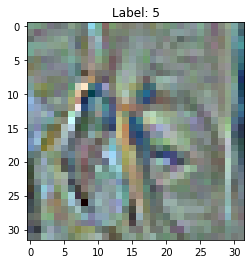

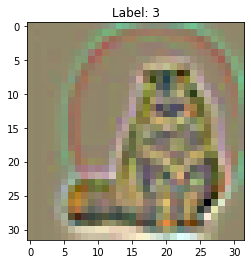

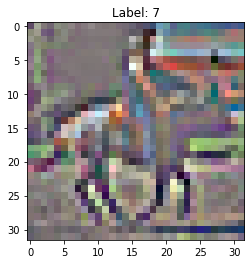

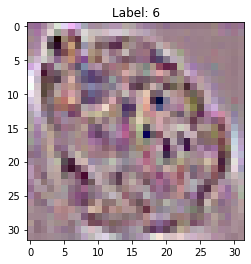

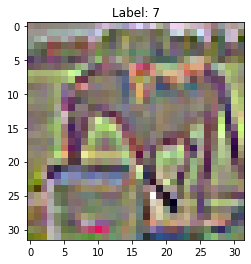

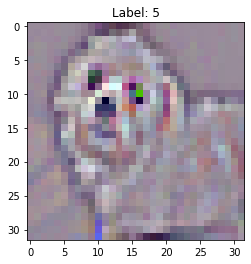

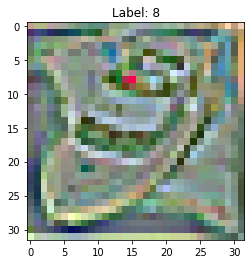

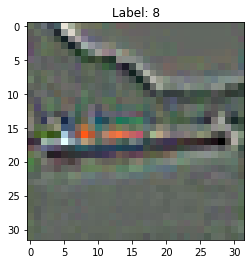

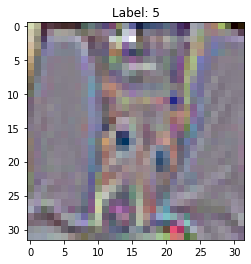

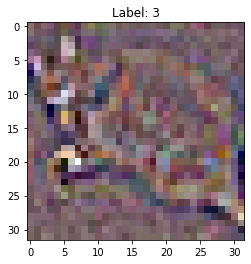

In [116]:
#Visualize the images of the first 5 samples
import cv2
for i in range(10,20):
    # image = np.reshape(np.array(X_train.loc[i]), (3,32,32)).astype(float)
    image = np.reshape(Xtr[i], (3, 32,32)).astype(float)

    #image = (image - image.min()) / (image.max() - image.min())
    
    # Separate color channels
    red_channel = image[0]
    green_channel = image[1]
    blue_channel = image[2]

    
    # Normalize each channel 
    red_channel = (red_channel- red_channel.min()) / (red_channel.max()-red_channel.min())
    green_channel = (green_channel - green_channel.min()) / (green_channel.max()-green_channel.min())
    blue_channel = (blue_channel - blue_channel.min()) / (blue_channel.max() - blue_channel.min())

    # Combine channels to form the original image
    original_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    
    plt.imshow(np.clip(original_image, a_min=0, a_max=1), vmin=0, vmax=1)
    plt.title('Label: '+str(Ytr[i]))
    plt.show()

Additionally, we will transform the data into grayscale images in order to try different approaches.

In [58]:
#Scale images to gray
Xtr = (Xtr - Xtr.min())/(Xtr.max() - Xtr.min())
print(Xtr.shape)
Xtr_aux = np.reshape(Xtr, (Xtr.shape[0], 3, 32, 32))
print(Xtr_aux.shape)
Xtr_gray = np.mean(Xtr_aux, axis=1)
print(Xtr_gray.shape)

(5000, 3072)
(5000, 3, 32, 32)
(5000, 32, 32)


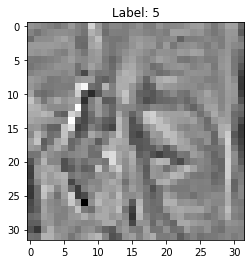

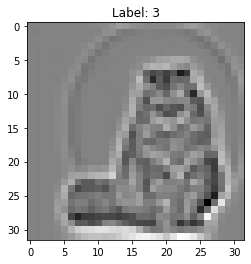

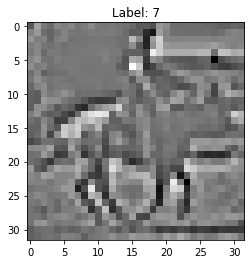

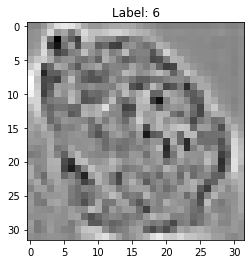

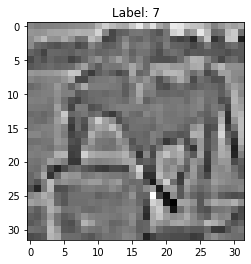

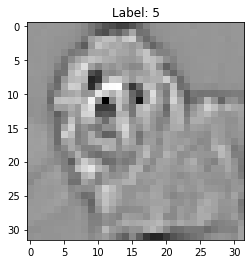

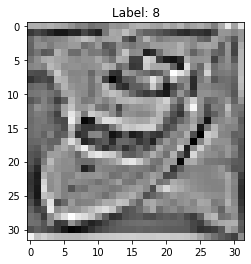

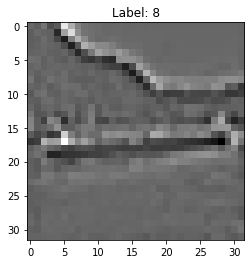

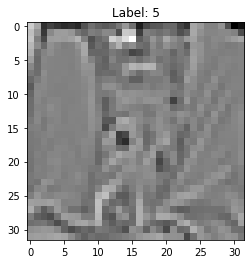

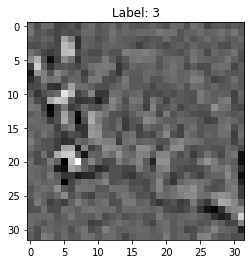

In [59]:
#Ilustrate the images of the first 5 sam
for i in range(10,20):
    image = Xtr_gray[i]
    plt.imshow(image, cmap='gray')
    plt.title('Label: '+str(Ytr[i]))
    plt.show()

In [ ]:
import cv2
for i in range(10,20):
    # image = np.reshape(np.array(X_train.loc[i]), (3,32,32)).astype(float)
    image = np.reshape(Xtr[i], (32,32,3)).astype(float)
    I = cv2.normalize(I, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

In [71]:
#Reshape gray images to be able to train with them
Xtr_gray = np.reshape(Xtr_gray, (Xtr_gray.shape[0], 32*32))

{0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500}


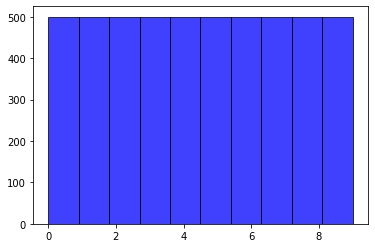

In [60]:
#Count the number of labels
unique, counts = np.unique(Ytr, return_counts=True)
print(dict(zip(unique, counts)))
#Visualize the distribution of the labels
plt.hist(Ytr, bins=10, alpha=0.75, color='blue', edgecolor='black')
plt.show()

**3. Generation of the train/validation set**

In order to have a good representation in both sets for all the classes we will do a stratified split and divide the data into 80% for training and 20% for validation.

In [72]:
# split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2, random_state=42, stratify= Ytr)

In [73]:
#Check that the distribution of the labels is the same in the training and validation set
unique, counts = np.unique(Y_train, return_counts=True)
print(f"Training data classes count: {dict(zip(unique, counts))}")

unique, counts = np.unique(Y_val, return_counts=True)
print(f"Validation data classes count: {dict(zip(unique, counts))}")

Training data classes count: {0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400, 7: 400, 8: 400, 9: 400}
Validation data classes count: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100}


In [74]:
len(X_train), len(X_val), len(Y_train), len(Y_val)

(4000, 1000, 4000, 1000)

**4. Baseline model**

Before doing any feature extraction from data we will compute a Multiclass Kernel SVC classifier with a gaussian kernel and consider it as baseline model.

In [75]:
#Define the kernel and the classifier
kernel = RBF(sigma=1)
multiKSVC = MulticlassKernelSVC(C=1, kernel=kernel)

In [76]:
#Training the classifier
multiKSVC.fit(X_train, Y_train)

Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done


In [77]:
#Compute the prediction over validation set to know the quality of the model
y_pred = multiKSVC.predict(X_val)
sum(y_pred == Y_val) / len(Y_val)

0.201

In [14]:
#Compute the prediction and generate the csv file to uplode for the challenge
Yte = multiKSVC.predict(Xte) 
Yte = {'Prediction' : Yte} 
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 
dataframe.to_csv('./Yte_pred.csv',index_label='Id')

--------------------------------------------------------------------------------------------------------------------------

In [122]:
#Trying with SIFT from opencv
import cv2

sift = cv2.SIFT_create()
keypoints = []
for image in range(len(Xtr_gray)):
    #print(Xtr_gray[image].shape)
    img = Xtr_gray[image].reshape(32,32).astype(np.float32)
    I = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    #print(I)
    kp, des = sift.detectAndCompute(I, None)
    keypoints.append(kp)
    
keypoints

[(< cv2.KeyPoint 0x74514de81470>, < cv2.KeyPoint 0x7451376f31b0>),
 (),
 (< cv2.KeyPoint 0x7451376f3270>,
  < cv2.KeyPoint 0x7451376f3240>,
  < cv2.KeyPoint 0x7451376f3210>),
 (< cv2.KeyPoint 0x7451376f30f0>,
  < cv2.KeyPoint 0x7451376f2fa0>,
  < cv2.KeyPoint 0x7451376f2f70>,
  < cv2.KeyPoint 0x74514ebc17a0>),
 (< cv2.KeyPoint 0x74514ebeab20>,
  < cv2.KeyPoint 0x745137801e00>,
  < cv2.KeyPoint 0x74514ea75ef0>,
  < cv2.KeyPoint 0x74514ea76a90>),
 (< cv2.KeyPoint 0x74514ea76910>,
  < cv2.KeyPoint 0x745137702eb0>,
  < cv2.KeyPoint 0x745148c60fc0>,
  < cv2.KeyPoint 0x745148c60f90>,
  < cv2.KeyPoint 0x745148c617d0>),
 (< cv2.KeyPoint 0x745148c613b0>,),
 (),
 (< cv2.KeyPoint 0x745148c614d0>,
  < cv2.KeyPoint 0x745148c612f0>,
  < cv2.KeyPoint 0x745148c612c0>),
 (< cv2.KeyPoint 0x745148c61290>,
  < cv2.KeyPoint 0x745148c61260>,
  < cv2.KeyPoint 0x745148c61230>,
  < cv2.KeyPoint 0x745148c611a0>,
  < cv2.KeyPoint 0x745148c61200>,
  < cv2.KeyPoint 0x745148c611d0>,
  < cv2.KeyPoint 0x745148c61050>

In [120]:
keypoints[0][0]

< cv2.KeyPoint 0x74514ceb0ff0>

In [29]:
# trying polynomial kernel
kernel = LinearKernel()

In [30]:
multiKSVC_poly = MulticlassKernelSVC(C=1, kernel=kernel)

In [31]:
multiKSVC_poly.fit(X_train, Y_train)

Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Building K - done
Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Building K - done
Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Building K - done
Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

In [32]:
y_pred_poly = multiKSVC_poly.predict(X_val)

In [33]:
sum(y_pred_poly == Y_val) / len(Y_val)

0.142

In [137]:
min(y_pred), max(y_pred)

(0, 9)

(array([161., 333., 233., 126., 179., 149., 114., 179., 153., 373.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

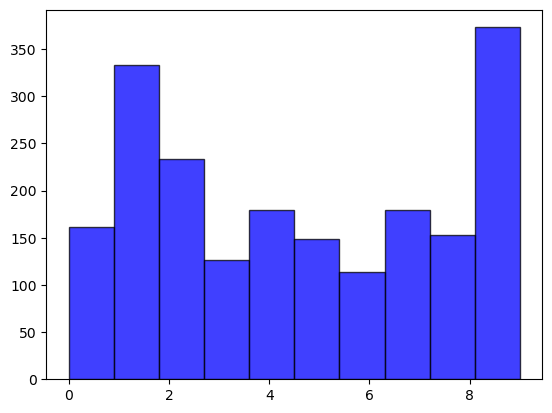

In [138]:
plt.hist(y_pred, bins=10, alpha=0.75, color='blue', edgecolor='black')

In [41]:
# Primero probando con las dos primeras etiquetas a ver q tal
indices= np.union1d(np.where(Ytr == 1)[0], np.where(Ytr == 2)[0])
len(indices)

1000

In [42]:
Y = Ytr[indices]
X = Xtr[indices]

In [44]:
# split X and Y into training and testing sets
from sklearn.model_selection import train_test_split
X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_tr), len(X_t), len(Y_tr), len(Y_t)

(800, 200, 800, 200)

In [50]:
# Split the data into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(4000, 3072) (1000, 3072) (4000,) (1000,)


In [97]:
kernel = RBF(sigma=5)

In [98]:
# train a linear SVM
classifier = KernelSVC(C=5, kernel=kernel)
classifier.fit(X_tr,np.array([1 if y == 1 else -1 for y in Y_tr]))

Building K...
Building K - done


In [48]:
# get the mean among the three channels
Xtr = Xtr.reshape(-1, 3, 32, 32).mean(axis=1).reshape(-1, 1024)
Xte = Xte.reshape(-1, 3, 32, 32).mean(axis=1).reshape(-1, 1024)

In [49]:
# split the data
X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2, random_state=42)

In [50]:
kernel = RBF(sigma=1)

In [54]:
multiKSVC_1 = MulticlassKernelSVC(C=1, kernel=kernel)

In [55]:
multiKSVC_1.fit(X_train, Y_train)

Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done


In [56]:
y_pred_1 = multiKSVC_1.predict(X_val)

In [57]:
sum(y_pred_1 == Y_val) / len(Y_val)

0.173